In [16]:
import os
import sys
import torch
from transformers import BertTokenizerFast, BertTokenizer
import lightning as pl

In [17]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))  
pl.seed_everything(42, workers=True)
torch.set_float32_matmul_precision(precision="high")


Seed set to 42


In [18]:
args = {
    "pretrain": '/home/zhulin/pretrain/bert_pretrain_uncased/',
    "model": "/home/zhulin/models/single_channel_transformer.ckpt",
    "dataset": "/home/zhulin/datasets/cdatasets.test.5.csv"
}

In [19]:
### load model
from core.predictor import SingleChannelPredictor
tokenizer = BertTokenizer.from_pretrained(args["pretrain"], use_fast=True)

ckpt = torch.load(args["model"])
predictor = SingleChannelPredictor(**ckpt["hyper_parameters"])
predictor.load_state_dict(ckpt["state_dict"])
predictor = predictor.eval().cuda()

In [68]:
# 定义预测函数
def predict(seqs):
    try:
        # 将输入文本转化为张量，并移动到GPU
        padded_sent_seq = tokenizer(seqs.tolist(), padding=True, truncation=True, max_length=2048, return_tensors="pt")
        input_ids = padded_sent_seq["input_ids"].to("cuda:0")
        attention_mask = padded_sent_seq["attention_mask"].to("cuda:0")
        
        # 进行预测
        with torch.no_grad():  # 不需要计算梯度
            outputs = predictor(input_ids, mask=attention_mask)
        return outputs.cpu().numpy()  # 返回模型的预测结果，并确保在CPU上处理
    except Exception as e:
        print(seqs)
        raise e


In [69]:
import shap
explainer = shap.Explainer(predict, tokenizer)

In [22]:
import datatable as dt
data = dt.fread(args["dataset"], fill=True)
# data = data[(dt.f.index == "k84c82835a5d21bbcf75a61706d8ab549") & (dt.f.pname == "@WanaDecryptor@.exe") & (dt.f.label == 1), :]
data = data[(dt.f.index == "k84c82835a5d21bbcf75a61706d8ab549") & (dt.f.pname == "@WanaDecryptor@.exe"), :]
data.head(3)

,C0,channel,index,label,pid,pname,unique_key
,▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪,▪,▪▪▪▪,▪▪▪▪,▪▪▪▪▪▪▪▪
0,1112341,ProcessStart @WanaDecryptor@.exe co ThreadStart 1292 ImageLoad C:\Windows\System32\ntdll.dll ImageLo…,k84c82835a5d21bbcf75a61706d8ab549,1,3428,@WanaDecryptor@.exe,2392525056
1,1112342,FileIOCreate CallStack RtlDestroyMemoryBlockLookaside _CIcos RtlNtStatusToDosError RtlNtStatusToDos…,k84c82835a5d21bbcf75a61706d8ab549,1,3428,@WanaDecryptor@.exe,2392525056
2,1112343,ImageLoad C:\Windows\System32\kernel32.dll CallStack RtlDestroyMemoryBlockLookaside LdrResRelease Ld…,k84c82835a5d21bbcf75a61706d8ab549,1,3428,@WanaDecryptor@.exe,2392525056


In [70]:
# 准备输入数据
texts = data.to_pandas()["channel"].to_list()
# 计算SHAP值
shap_values = explainer(texts[2:])


PartitionExplainer explainer: 962it [21:22,  1.34s/it]                           


In [71]:
import pickle
pickle.dump(shap_values, open("./shap_values.pk", "wb"))

In [72]:
import pickle
shap_values = pickle.load(open("./shap_values.pk", "rb"))

In [73]:
import numpy as np
import datatable as dt
df_shap = dt.Frame({
    "token": np.concatenate(shap_values.data), 
    "shap_value": np.concatenate(shap_values.values).flatten()})
df_shap_imp = df_shap[:, [dt.f.token, dt.math.abs(dt.f.shap_value)]][:, {
    "shap_value": dt.sum(dt.f.shap_value)
}, dt.by(dt.f.token)][:, :, dt.sort(dt.f.shap_value, reverse=True)].to_pandas()

In [74]:
df_shap

,token,shap_value
,▪▪▪▪,▪▪▪▪▪▪▪▪
0,,−0.00474077
1,imageload,−0.0457081
2,c,0.0341782
3,:,0.00903866
4,\,−0.00984389
5,windows,−0.0132144
6,\,−0.00751272
7,system,−0.0150123
8,32,0.00359243


In [28]:
import shap
# 可视化SHAP值
shap.plots.text(shap_values[0])  # 显示第一个文本的SHAP值
shap.plots.text(shap_values[1])  # 显示第二个文本的SHAP值
shap.plots.text(shap_values[2])  # 显示第一个文本的SHAP值
shap.plots.text(shap_values[3])  # 显示第二个文本的SHAP值
shap.plots.text(shap_values[4])  # 显示第一个文本的SHAP值
shap.plots.text(shap_values[5])  # 显示第二个文本的SHAP值
shap.plots.text(shap_values[6])  # 显示第一个文本的SHAP值
shap.plots.text(shap_values[7])  # 显示第二个文本的SHAP值

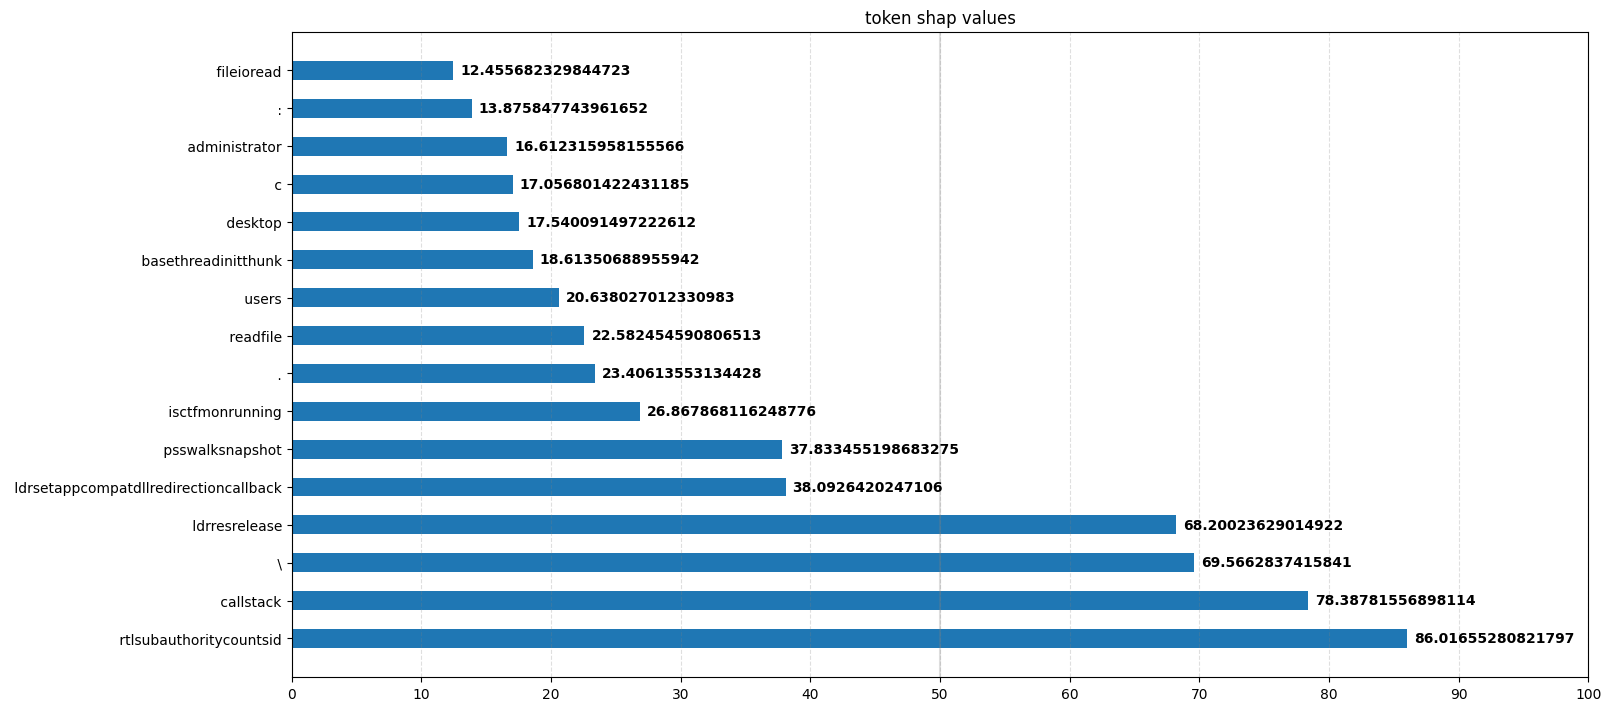

In [75]:
import numpy as np
import datatable as dt
# df_shap = dt.Frame({
#     "token": np.concatenate(shap_values.data), 
#     "shap_value": np.concatenate(shap_values.values).flatten()})
df_shap_imp = df_shap[:, [dt.f.token, dt.math.abs(dt.f.shap_value)]][:, {
    "shap_value": dt.sum(dt.f.shap_value)
}, dt.by(dt.f.token)][:, :, dt.sort(dt.f.shap_value, reverse=True)].to_pandas()

import matplotlib.pyplot as plt
import numpy as np

tokens = df_shap_imp["token"].to_numpy()
vshap = df_shap_imp["shap_value"].to_numpy()
fig, ax1 = plt.subplots(figsize=(16, 7), layout='constrained')
fig.canvas.manager.set_window_title('Eldorado K-8 Fitness Chart')
ax1.set_title("token shap values")
rects = ax1.barh(tokens[:16], vshap[:16], align='center', height=0.5)
# Partition the percentile values to be able to draw large numbers in
# white within the bar, and small numbers in black outside the bar.
ax1.bar_label(rects, vshap[:16], padding=5, color='black', fontweight='bold')
# ax1.bar_label(rects, large_percentiles, padding=-32, color='white', fontweight='bold')
ax1.set_xlim([0, 100])
ax1.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax1.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax1.axvline(50, color='grey', alpha=0.25)  # median position

plt.show()